In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import copy
from itertools import repeat
import shutil
import time
import math
import array

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import optuna
from joblib import Parallel, delayed, dump, load
from joblib.externals.loky import get_reusable_executor

from ray import train, tune
from ray.tune.search.optuna import OptunaSearch

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from cmaes import CMAwM

from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-whitegrid')

# Load data

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


# Clean-up and transform data

In [5]:
# drop columns with NaN
df.dropna(axis=1, inplace=True)
# drop irrelevant columns
df.drop(columns=['Id'], inplace=True)
# drop major outliers
df = df[df['BsmtFinSF1'] <= 5000]
df = df[df['MiscVal'] <= 5000]
df = df[df['LotArea'] <= 100000]

In [6]:
columns_non_categorical = df.select_dtypes(exclude='object').columns.to_list()
columns_non_categorical.sort()
columns_non_categorical.remove('SalePrice')
columns_non_categorical = ['SalePrice'] + columns_non_categorical

In [7]:
# alphabetically sort columns, keep target first
df_temp = df[['SalePrice']]
df.drop(columns=['SalePrice'], inplace=True)
df.sort_index(axis=1, inplace=True)
df = pd.concat([df_temp, df], axis=1)
del df_temp
df

,SalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,208500,856,854,0,3,1Fam,706,0,1,0,...,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
1,181500,1262,0,0,3,1Fam,978,0,0,1,...,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
2,223500,920,866,0,3,1Fam,486,0,1,0,...,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
3,140000,961,756,0,3,1Fam,216,0,1,0,...,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
4,250000,1145,1053,0,4,1Fam,655,0,1,0,...,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,953,694,0,3,1Fam,0,0,0,0,...,WD,0,Pave,7,953,AllPub,0,1999,2000,2007
1456,210000,2073,0,0,3,1Fam,790,163,1,0,...,WD,0,Pave,7,1542,AllPub,349,1978,1988,2010
1457,266500,1188,1152,0,4,1Fam,275,0,0,0,...,WD,0,Pave,9,1152,AllPub,0,1941,2006,2010
1458,142125,1078,0,0,2,1Fam,49,1029,1,0,...,WD,0,Pave,5,1078,AllPub,366,1950,1996,2010


# Examine the data after transformations

Histograms:

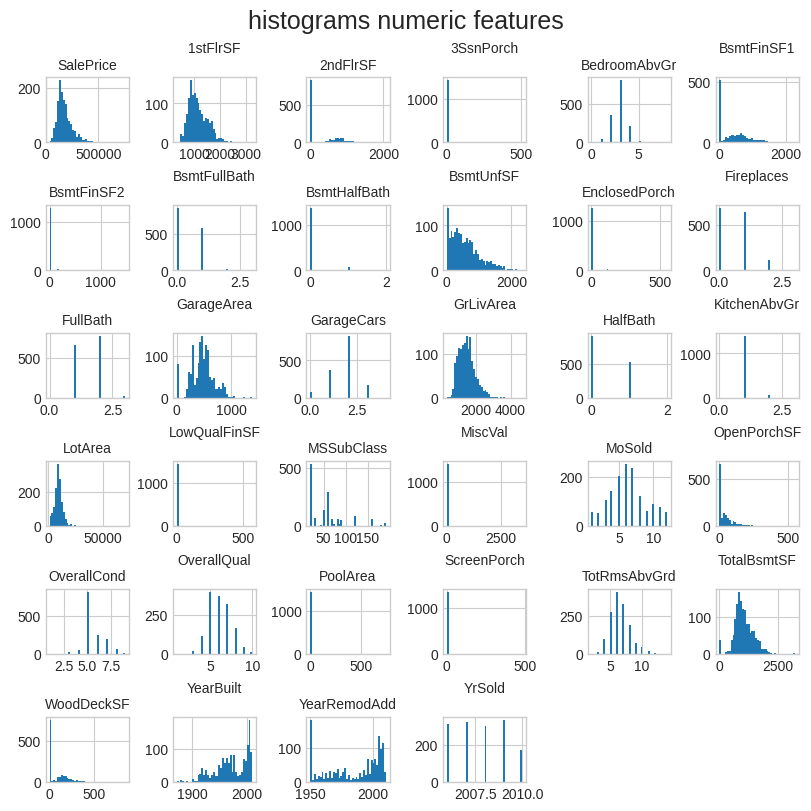

In [8]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('histograms numeric features', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate(df.select_dtypes(exclude='object').columns, 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax.hist(df[item], bins=40)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

Box plots:

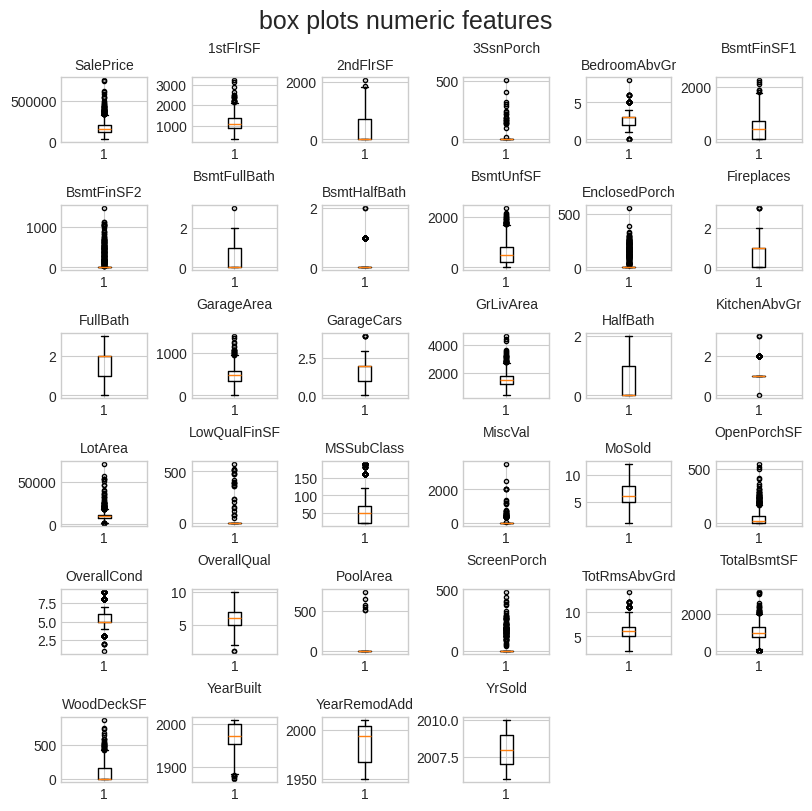

In [9]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('box plots numeric features', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate(df.select_dtypes(exclude='object').columns, 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax.boxplot(df[item], sym='.')
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

Scatterplots:

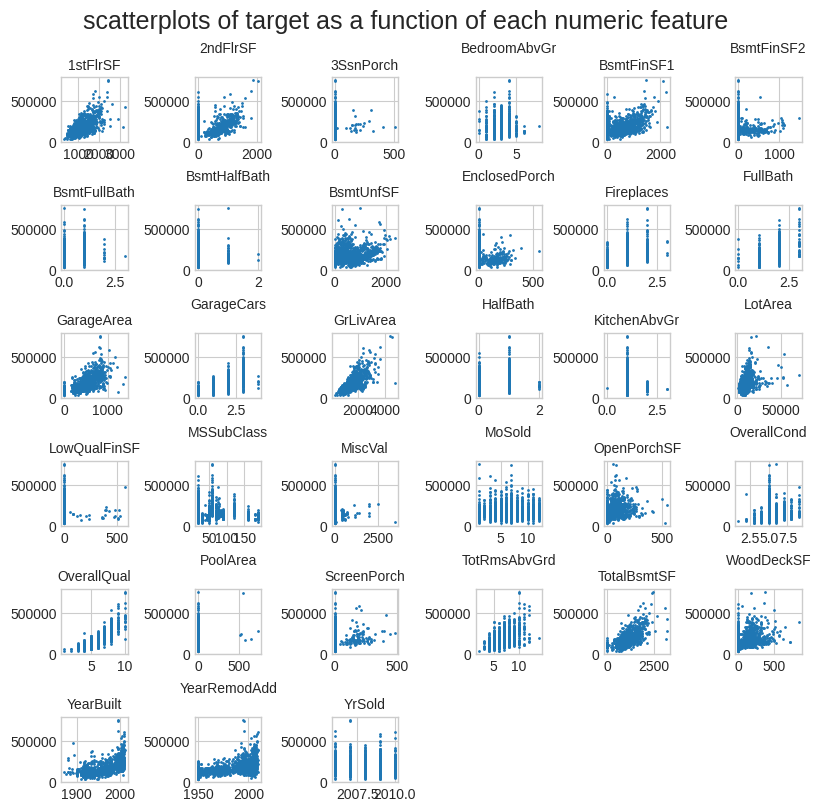

In [10]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('scatterplots of target as a function of each numeric feature', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate([f for f in df.select_dtypes(exclude='object').columns if f not in ['SalePrice']], 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
    plt.scatter(df[item], df['SalePrice'], s=1)
plt.show()

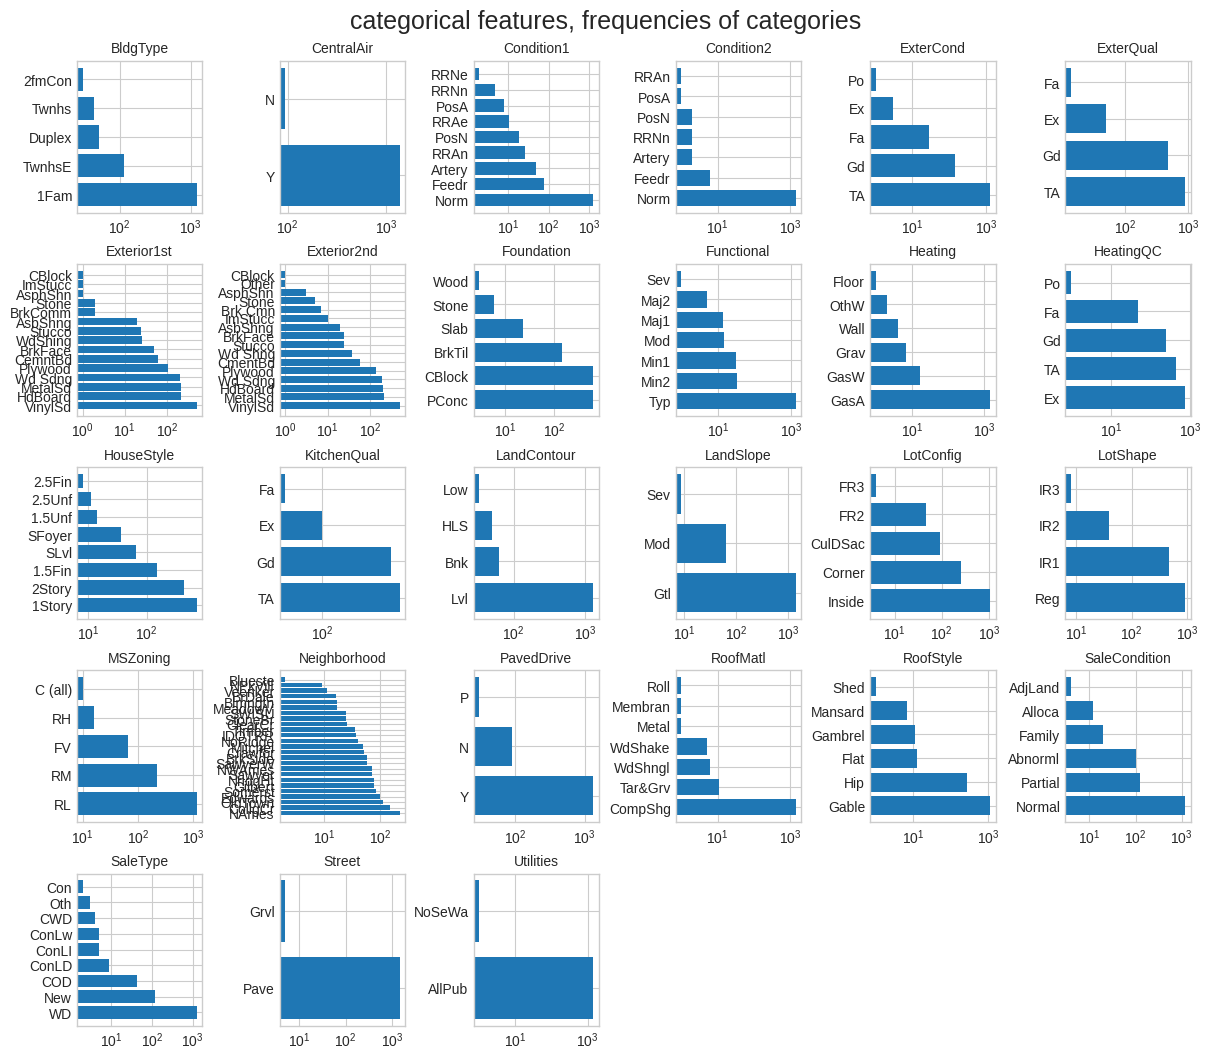

In [11]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.suptitle('categorical features, frequencies of categories', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(include='object').shape[1]))
for i, item in enumerate(df.select_dtypes(include='object').columns, 1):
    vcounts = df[item].value_counts()
    ax = plt.subplot(grid_size, grid_size, i)
    ax.barh(vcounts.index.to_list(), vcounts.values.tolist(), log=True)
    ax_title = item
    #if i % 2 == 0:
    #    ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

In [13]:
# dummy categorical columns
df = pd.concat([df.select_dtypes(exclude='object'), pd.get_dummies(df.select_dtypes(include='object'), dtype=int)], axis=1)
# alphabetically sort columns, keep target first
df_temp = df[['SalePrice']]
df.drop(columns=['SalePrice'], inplace=True)
df.sort_index(axis=1, inplace=True)
df = pd.concat([df_temp, df], axis=1)
del df_temp
df

,SalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,208500,856,854,0,3,1,0,0,0,0,...,0,1,8,856,1,0,0,2003,2003,2008
1,181500,1262,0,0,3,1,0,0,0,0,...,0,1,6,1262,1,0,298,1976,1976,2007
2,223500,920,866,0,3,1,0,0,0,0,...,0,1,6,920,1,0,0,2001,2002,2008
3,140000,961,756,0,3,1,0,0,0,0,...,0,1,7,756,1,0,0,1915,1970,2006
4,250000,1145,1053,0,4,1,0,0,0,0,...,0,1,9,1145,1,0,192,2000,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,953,694,0,3,1,0,0,0,0,...,0,1,7,953,1,0,0,1999,2000,2007
1456,210000,2073,0,0,3,1,0,0,0,0,...,0,1,7,1542,1,0,349,1978,1988,2010
1457,266500,1188,1152,0,4,1,0,0,0,0,...,0,1,9,1152,1,0,0,1941,2006,2010
1458,142125,1078,0,0,2,1,0,0,0,0,...,0,1,5,1078,1,0,366,1950,1996,2010


Correlation heatmap:

Red is positive. Blue is negative. Black is 0.
Target is first in the list. The features are alphabetically sorted.
Download the image and view it locally.


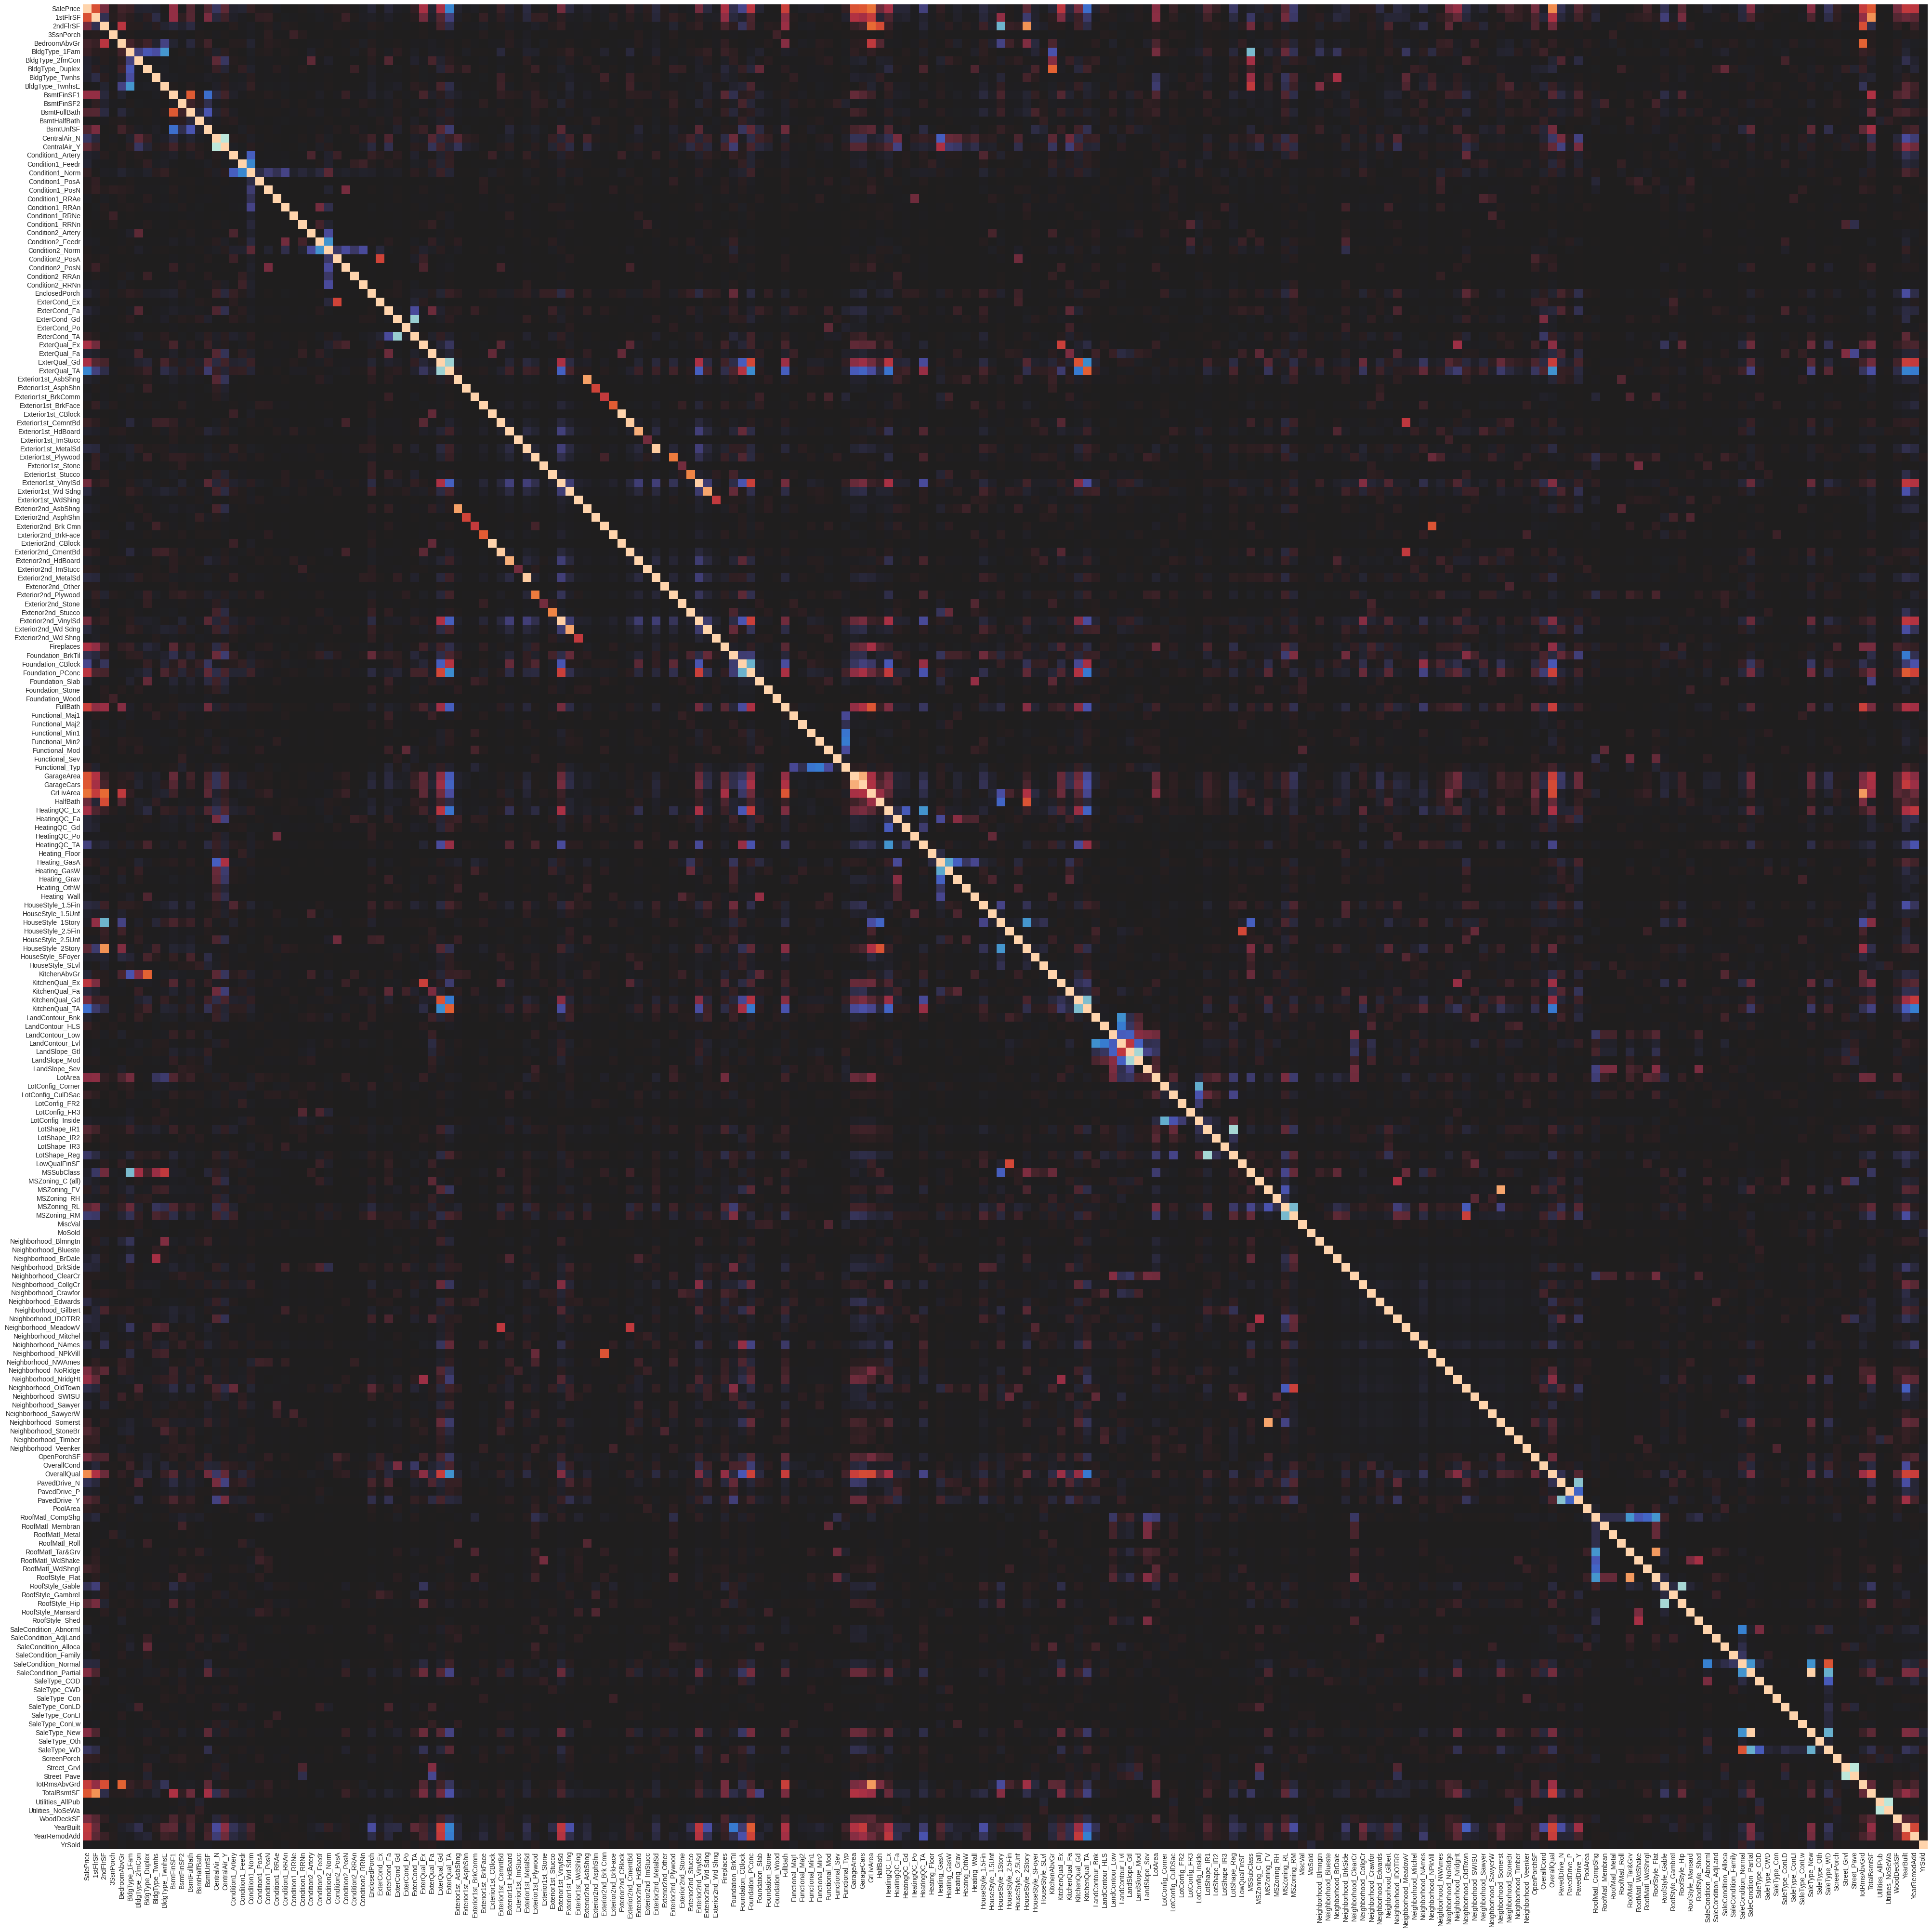

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(40, 40), layout="constrained")
ax = sns.heatmap(df.corr(method='pearson'), center=0.0, cmap='icefire', cbar=False, cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)}, square=True)
# fig.suptitle('Pearson correlation', fontsize=18)
print('Red is positive. Blue is negative. Black is 0.')
print('Target is first in the list. The features are alphabetically sorted.')
print('Download the image and view it locally.')
fig.show()

# Fit linear model

In [16]:
X = df.drop(columns=['SalePrice']).copy()
y = df['SalePrice'].copy()
X = add_constant(X)

In [19]:
linear_model = sm.OLS(y, X).fit()
print(linear_model.summary2())

                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.909     
Dependent Variable:         SalePrice              AIC:                      33598.3912
Date:                       2024-01-05 14:21       BIC:                      34570.1662
No. Observations:           1453                   Log-Likelihood:           -16615.   
Df Model:                   183                    F-statistic:              80.14     
Df Residuals:               1269                   Prob (F-statistic):       0.00      
R-squared:                  0.920                  Scale:                    5.7376e+08
---------------------------------------------------------------------------------------
                         Coef.       Std.Err.     t    P>|t|     [0.025       0.975]   
---------------------------------------------------------------------------------------
const                  -82798.5920 156446.7227 -0.5292 0.596

# Feature selection

## Sequential forward search

In [20]:
class DummyEstimator(BaseEstimator):
    # mlxtend wants to use an sklearn estimator, which is not needed here
    # (statsmodels OLS is used instead)
    # create a dummy estimator to pacify mlxtend
    def fit(self, X, y=None, **kwargs):
        return self


def neg_aic(m, X, y):
    # return -AIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.aic


def neg_bic(m, X, y):
    # return -BIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.bic


seq_selector = SFS(
    DummyEstimator(),
    k_features=(1, X.shape[1]),
    forward=True,
    floating=False,
    scoring=neg_bic,
    cv=None,
    n_jobs=-1,
    verbose=1,
    # make sure the intercept is not dropped
    fixed_features=['const'],
)

Run SFS:

In [21]:
# mlxtend will mess with your dataframes if you don't .copy()
seq_res = seq_selector.fit(X.copy(), y.copy())
seq_metrics = seq_res.get_metric_dict()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 213 out of 213 | elapsed:    1.1s finished
Features: 2/214[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    0.1s finished
Features: 3/214[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 211 out of 211 | elapsed:    0.1s finished
Features: 4/214[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.1s finished
Features: 5/214[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 209 out of

Display results:

In [22]:
best_score = -np.inf
r2_of_best_k = 0
r2_list = []
best_k = 1
bfi = []

# also extract R2 from the feature selection search
for k in tqdm(seq_metrics.keys()):
    r2_eval_mod = sm.OLS(y, X[list(seq_metrics[k]['feature_names'])], hasconst=True)
    r2_eval_mod_res = r2_eval_mod.fit()
    r2 = r2_eval_mod_res.rsquared
    r2_list.append(r2)
    score_k = seq_metrics[k]['avg_score']
    if score_k > best_score:
        best_score = score_k
        best_k = k
        bfi = list(seq_metrics[k]['feature_names'])
        r2_of_best_k = r2

print(f'best k:        {best_k}')
print(f'best score:    {-best_score}')
print(f'R2 @ best k:   {r2_of_best_k}')
print(f'best features: {bfi}')

  0%|          | 0/214 [00:00<?, ?it/s]

best k:        36
best score:    33708.98602877906
R2 @ best k:   0.9075677543649224
best features: ['const', 'BedroomAbvGr', 'BldgType_1Fam', 'BsmtFinSF1', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'Functional_Sev', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'KitchenQual_Ex', 'LandContour_HLS', 'LotArea', 'LotConfig_CulDSac', 'LowQualFinSF', 'MSSubClass', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_New', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt']


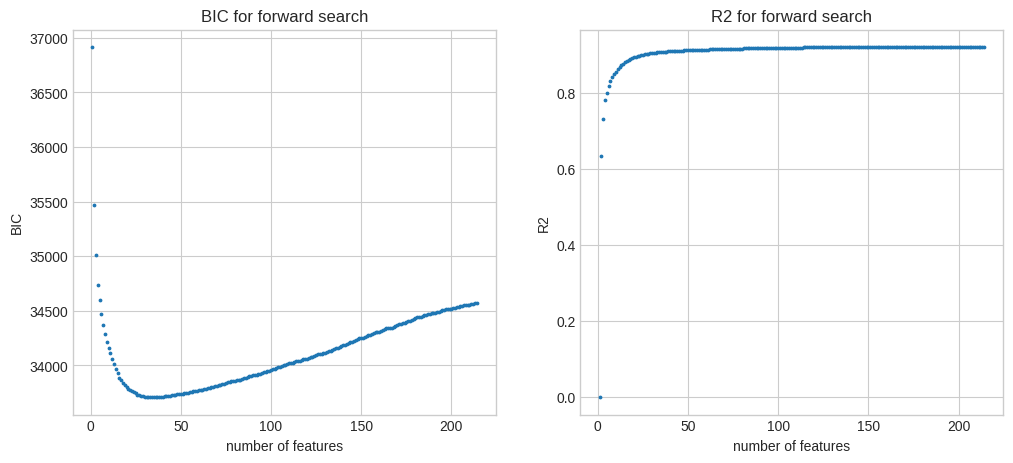

In [23]:
sfs_avg = [-seq_metrics[k]['avg_score'] for k in sorted(seq_metrics.keys())]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(sorted(seq_metrics.keys()), sfs_avg, s=3)
ax[0].set_xticks(sorted(seq_metrics.keys()), minor=True)
ax[0].set_title('BIC for forward search')
ax[0].set_xlabel('number of features')
ax[0].set_ylabel('BIC')
ax[1].scatter(sorted(seq_metrics.keys()), r2_list, s=3)
ax[1].set_title('R2 for forward search')
ax[1].set_xlabel('number of features')
ax[1].set_ylabel('R2')
fig.show()

In [40]:
X_seq = X[list(seq_metrics[best_k]['feature_names'])].copy()

linear_model_seq = sm.OLS(y, X_seq, hasconst=True).fit()
print(linear_model_seq.summary2())

                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.905     
Dependent Variable:         SalePrice              AIC:                      33518.8561
Date:                       2024-01-05 14:28       BIC:                      33708.9860
No. Observations:           1453                   Log-Likelihood:           -16723.   
Df Model:                   35                     F-statistic:              397.5     
Df Residuals:               1417                   Prob (F-statistic):       0.00      
R-squared:                  0.908                  Scale:                    5.9638e+08
---------------------------------------------------------------------------------------
                        Coef.      Std.Err.     t     P>|t|      [0.025       0.975]   
---------------------------------------------------------------------------------------
const                -932259.6333 70652.6528 -13.1950 0.0000

In [41]:
def compute_vifs(df, drop_columns=['const']):
    df = df.copy()
    vif_list = []
    vif_names = []

    for i, cname in enumerate([c for c in df.columns.to_list() if c not in drop_columns]):
        try:
            vif = variance_inflation_factor(df, i)
        except Exception as e:
            vif = pd.NA
        vif_list.append(vif)
        vif_names.append(cname)

    vif_df = pd.DataFrame(vif_list, index=vif_names, columns=['vif'])
    vif_df.sort_values(by='vif', ascending=False, inplace=True)
    return vif_df


vif_lin = compute_vifs(X_seq)
vif_lin

,vif
BedroomAbvGr,12161.915989
Neighborhood_BrkSide,4.701169
BsmtFinSF1,4.392250
HeatingQC_Ex,3.824029
PoolArea,3.477158
WoodDeckSF,2.492930
ScreenPorch,2.239117
GrLivArea,1.871476
SaleType_New,1.818894
BldgType_1Fam,1.806077


## Genetic algorithm

### Non-optimized version

Based on:

https://deap.readthedocs.io/en/master/examples/ga_onemax_short.html

Appropriate for small and medium-sized problems.

In [43]:
# to maximize the objective
# fitness_weights = 1.0
# to minimize the objective
fitness_weights = -1.0

# copy the original dataframes into local copies, once
X_ga = X.copy()
y_ga = y.copy()

# 'const' (the first column) is not an actual feature, do not include it
X_features = X_ga.columns.to_list()[1:]

try:
    del creator.FitnessMax
    del creator.Individual
except Exception as e:
    pass

creator.create("FitnessMax", base.Fitness, weights=(fitness_weights,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

try:
    del toolbox
except Exception as e:
    pass

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    # create True/False selector list for features, and add True at the start for 'const'
    cols_select = [True] + [i == 1 for i in list(individual)]
    # fit model using the features selected from the individual
    lin_mod = sm.OLS(y_ga, X_ga.loc[:, cols_select], hasconst=True).fit()
    return (lin_mod.bic,)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

random.seed(0)
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, halloffame=hof, verbose=True)

best_individual = list(hof[0])
best_features = [X_features[i] for i, val in enumerate(best_individual) if val == 1]
best_objective = sm.OLS(y_ga, X_ga[['const'] + best_features], hasconst=True).fit().bic
print(f'best BIC: {best_objective}')
print(f'best features: {best_features}')

gen	nevals
0  	300   
1  	170   
2  	189   
3  	167   
4  	177   
5  	197   
6  	189   
7  	159   
8  	169   
9  	166   
10 	192   
best BIC: 34113.44040982577
best features: ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_TwnhsE', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_RRAn', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAn', 'ExterCond_Po', 'ExterQual_Ex', 'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_Other', 'Exterior2nd_Wd Shng', 'Fireplaces', 'Foundation_CBlock', 'Foundation_Slab', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HouseStyle_2.5Fin', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'KitchenAbvGr', 'KitchenQual_Ex'

In [44]:
# clean-up
try:
    del creator.FitnessMax
    del creator.Individual
    del toolbox
except Exception as e:
    pass

## Genetic algorithm, optimized version

Loosely based on:

https://deap.readthedocs.io/en/master/examples/ga_onemax.html

But it's heavily modified.

Appropriate for large-sized problems.

In [62]:
# to maximize the objective
# fitness_weights = 1.0
# to minimize the objective
fitness_weights = -1.0

# copy the original dataframes into local copies, once
X_ga = X.astype(float).copy()
y_ga = y.astype(float).copy()

# 'const' (the first column) is not an actual feature, do not include it
X_features = X_ga.columns.to_list()[1:]

try:
    del creator.FitnessMax
    del creator.Individual
except Exception as e:
    pass

creator.create("FitnessMax", base.Fitness, weights=(fitness_weights,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

try:
    del toolbox
except Exception as e:
    pass

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalMany(individuals):
    # individuals is an array of shape (n_individuals, n_features)
    # transform it into a list of lists:
    # - a list of individuals
    # - each individual is a list of feature selectors
    ind_list = [list(i) for i in list(individuals)]
    ret = []
    for ind in ind_list:
        # create a list of True/False feature selectors from each individual
        # pre-pend True to always select the 'const' feature
        cols_select = [True] + [i == 1 for i in list(ind)]
        # fit model using the features selected from the individual
        lin_mod = sm.OLS(y_ga, X_ga.loc[:, cols_select], hasconst=True).fit()
        ret.append((lin_mod.bic,))
    return ret


# multiprocess pool to evaluate individuals
def joblib_map(f, njobs, *iters):
    return Parallel(n_jobs=njobs)(delayed(f)(*args) for args in zip(*iters))


def selElitistAndTournament(individuals, k_tournament, k_elitist=0, tournsize=3):
    # elitist tournament
    # in addition to the regular tournament, ensure the top #k_elistist individuals are preserved
    return tools.selBest(individuals, k_elitist) + tools.selTournament(individuals, k_tournament, tournsize)


# Hyperparameters
population_size = 1000
crossover_probability = 0.5
individual_mutation_probability = 0.2
gene_mutation_probability = 0.1
tournament_size = 3
elite_size = 0

n_jobs = os.cpu_count()

# register the pool as the mapper
# and the custom function as the evaluator
toolbox.register("map_multi", joblib_map)
toolbox.register("evaluate", evalMany)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=gene_mutation_probability)
# toolbox.register("select", tools.selTournament, tournsize=tournament_size)
# selection with tournament and optional elitism
toolbox.register(
    "select",
    selElitistAndTournament,
    k_tournament=population_size - elite_size,
    k_elitist=elite_size,
    tournsize=tournament_size,
)

random.seed(0)
population = toolbox.population(n=population_size)
hall_of_fame = tools.HallOfFame(1)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in population if not ind.fitness.valid]
# split the population in a list with n_jobs elements
# each element is an array containing multiple individuals
# send individuals to the evaluator
fitnesses_nested = toolbox.map_multi(toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs))
fitnesses = []
for l in fitnesses_nested:
    fitnesses += l
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

hall_of_fame.update(population)

n_gen = 1000
best_objective_per_gen = np.full(n_gen, np.nan)
best_objective = np.nan
best_generation = 0
gene_values_mean = np.zeros((n_gen, len(X_features)))
gene_maes = np.full(n_gen, np.nan)
time_to_best = np.inf
# Begin the generational process
iterator = tqdm(range(1, n_gen + 1), desc='generation')
t_start = time.time()
for gen in iterator:
    t_start_loop = time.time()

    # Select the next generation of individuals
    offspring = toolbox.select(population)
    # Vary the pool of individuals via cross-over and mutation
    offspring = algorithms.varAnd(offspring, toolbox, crossover_probability, individual_mutation_probability)
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    # split the population in a list with n_jobs elements
    # each element is an array containing multiple individuals
    # send list to the evaluator pool
    fitnesses_nested = toolbox.map_multi(toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs))
    fitnesses = []
    for l in fitnesses_nested:
        fitnesses += l
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # Update the hall of fame with the generated individuals
    hall_of_fame.update(offspring)
    # Replace the current population by the offspring
    population[:] = offspring

    t_end_loop = time.time()

    # record the mean gene values across the population
    gene_values_mean[gen - 1, :] = np.array(population).mean(axis=0)
    if gen >= 2:
        gene_maes[gen - 1] = mean_absolute_error(gene_values_mean[gen - 2, :], gene_values_mean[gen - 1, :])
    # pick best individual for stats recording
    best_individual = tools.selBest(population, 1)[0]
    best_objective_per_gen[gen - 1] = best_individual.fitness.values[0]
    if (
        best_objective is np.nan
        or fitness_weights * best_individual.fitness.values[0] > fitness_weights * best_objective
    ):
        best_objective = best_individual.fitness.values[0]
        best_generation = gen
        time_to_best = t_end_loop - t_start
        print(
            f'gen: {gen:4n}, curr/prev gene MAE: {gene_maes[gen - 1]:.4f}, new best objective: {best_objective:.4f}, time to best: {time_to_best:.4f}'
        )

    if os.path.isfile('break'):
        # to gracefully break the loop, manually create a file called 'break'
        print(f'Found break file, stopping now.')
        iterator.close()
        break
g_completed = gen

best_individual = list(hall_of_fame[0])
best_features = [X_features[i] for i, val in enumerate(best_individual) if val == 1]
best_objective = sm.OLS(y_ga, X_ga[['const'] + best_features], hasconst=True).fit().bic

print()
print(f'best objective:  {best_objective}')
print(f'best generation: {best_generation}')
print(f'time to best:    {time_to_best:.4f}')
print(f'best features:   {best_features}')

generation:   0%|          | 0/1000 [00:00<?, ?it/s]

gen:    1, curr/prev gene MAE: nan, new best objective: 34284.6978, time to best: 0.6044
gen:    2, curr/prev gene MAE: 0.0235, new best objective: 34237.2278, time to best: 1.2468
gen:    3, curr/prev gene MAE: 0.0256, new best objective: 34214.3002, time to best: 1.9874
gen:    4, curr/prev gene MAE: 0.0260, new best objective: 34180.4923, time to best: 2.7442
gen:    5, curr/prev gene MAE: 0.0246, new best objective: 34154.9253, time to best: 3.4984
gen:    6, curr/prev gene MAE: 0.0285, new best objective: 34139.4376, time to best: 4.2539
gen:    7, curr/prev gene MAE: 0.0290, new best objective: 34117.7662, time to best: 4.9910
gen:    8, curr/prev gene MAE: 0.0265, new best objective: 34100.1204, time to best: 5.6216
gen:   10, curr/prev gene MAE: 0.0234, new best objective: 34087.7337, time to best: 6.8384
gen:   11, curr/prev gene MAE: 0.0242, new best objective: 34056.6133, time to best: 7.5522
gen:   12, curr/prev gene MAE: 0.0278, new best objective: 34043.8180, time to best

```
best value from sfs:    33708.98602877906

best value from optuna: ???

best ga so far:         33708.79501230639

population_size = 400
crossover_probability = 0.5
individual_mutation_probability = 0.2
gene_mutation_probability = 0.05
tournament_size = 3
elite_size = 0

best ga so far:         33705.569572544795

population_size = 1000
crossover_probability = 0.5
individual_mutation_probability = 0.2
gene_mutation_probability = 0.1
tournament_size = 3
elite_size = 0
```

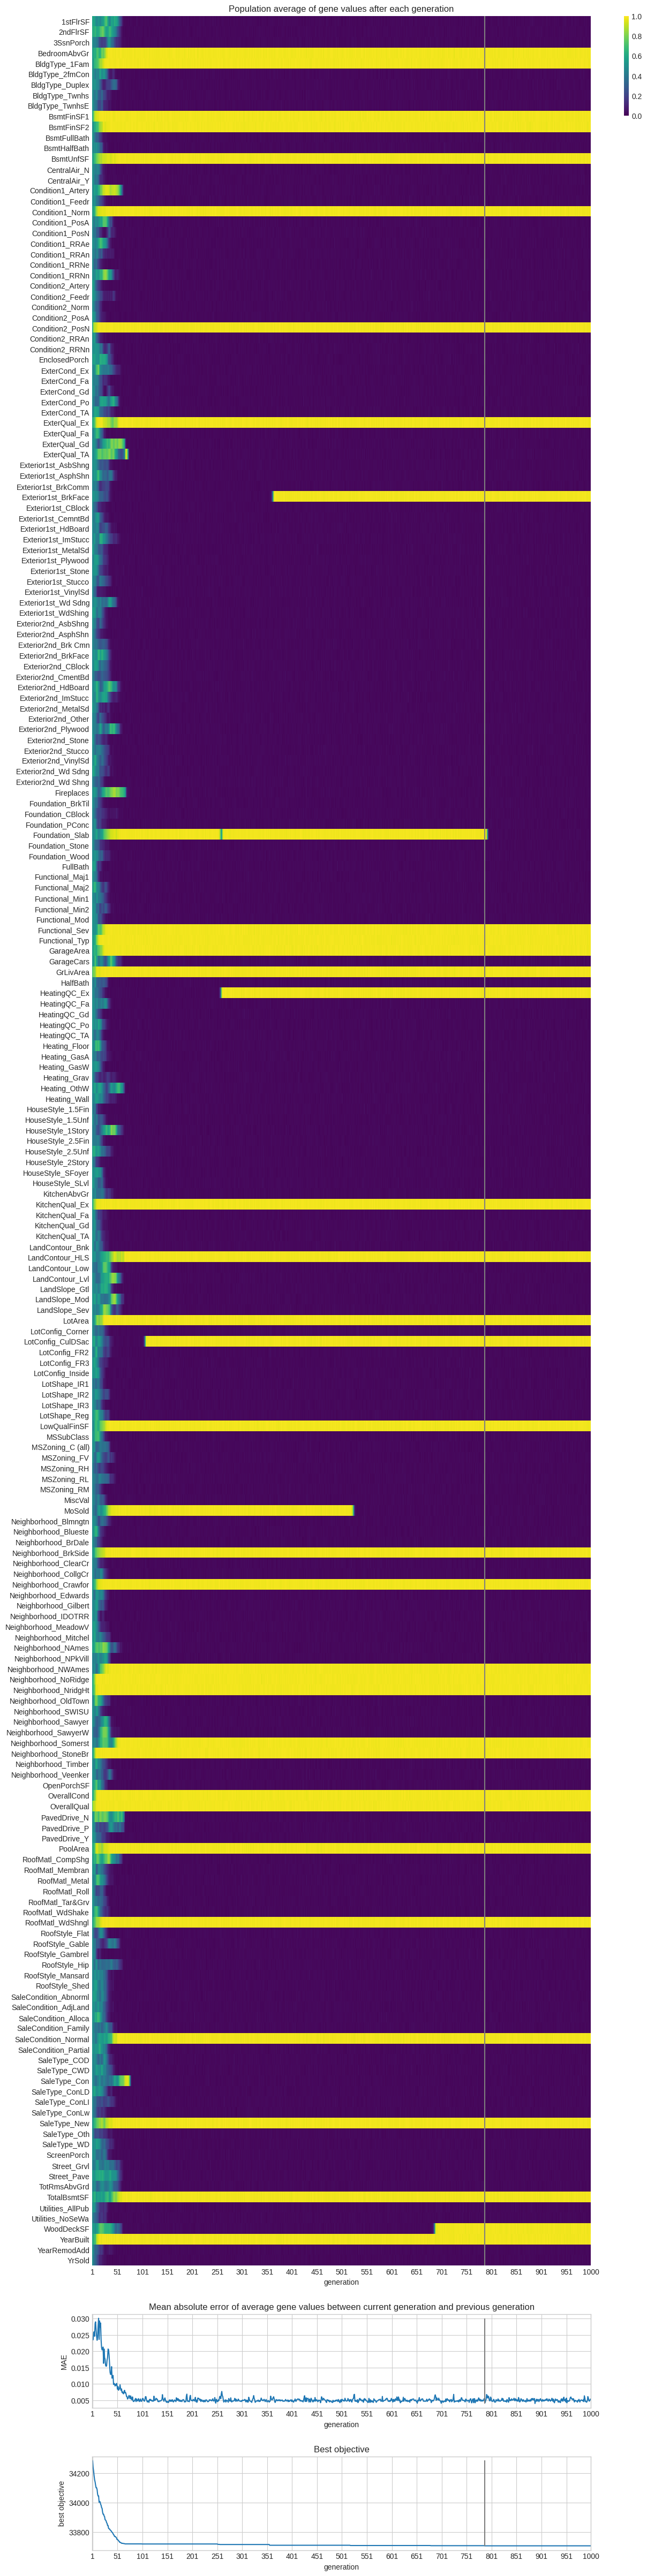

In [63]:
gvm_df = (
    pd.DataFrame(gene_values_mean, columns=X_features, index=range(1, gene_values_mean.shape[0] + 1))
    .sort_index(axis=1)
    .iloc[:g_completed]
)
if g_completed > 20:
    x_ticks = list(range(1, g_completed + 1, round(g_completed / 20)))
else:
    x_ticks = list(range(1, g_completed + 1))
if x_ticks[-1] != g_completed:
    x_ticks.append(g_completed)

fig, ax = plt.subplots(3, 1, sharex=True, height_ratios=[24, 1, 1], figsize=(12, 48), layout='constrained')

sns.heatmap(
    gvm_df.sort_index(axis=1).T,
    vmin=0.0,
    vmax=1.0,
    cmap='viridis',
    cbar=True,
    cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)},
    ax=ax[0],
)
ax[0].set_title('Population average of gene values after each generation')
ax[0].axvline(x=best_generation, color='C7')
ax[0].set_xlabel('generation')
ax[0].tick_params(axis='both', reset=True)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_ticks)

ax[1].set_xlabel('generation')
ax[1].plot(list(range(2, g_completed + 1)), gene_maes[1:g_completed])
ax[1].vlines(x=best_generation, ymin=gene_maes[1:g_completed].min(), ymax=gene_maes[1:g_completed].max(), colors='C7')
ax[1].set_xlabel('generation')
ax[1].set_ylabel('MAE')
ax[1].set_title('Mean absolute error of average gene values between current generation and previous generation')
ax[1].tick_params(axis='both', reset=True)

ax[2].set_xlabel('generation')
ax[2].plot(list(range(1, g_completed + 1)), best_objective_per_gen[:g_completed])
ax[2].vlines(
    x=best_generation,
    ymin=min(best_objective_per_gen[:g_completed]),
    ymax=max(best_objective_per_gen[:g_completed]),
    colors='C7',
)
ax[2].set_xlabel('generation')
ax[2].set_ylabel('best objective')
ax[2].set_title('Best objective')

fig.show()

# Feature selection with Ray Tune

In [64]:
def aic(m, X, y):
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return lin_mod_res.aic


def bic(m, X, y):
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return lin_mod_res.bic


def ray_objective(trial, X, y, features):
    # for CmaEsSampler and QMCSampler
    features_use = ['const'] + [f for f in features if trial[f] == 1]
    # for NSGA*Sampler
    # features_use = ['const'] + [f for f in features if trial[f] == 1]
    return {'score': bic(None, X[features_use], y)}


def define_search_space(trial: optuna.Trial):
    features = copy.deepcopy(features_select)
    random.shuffle(features)
    _ = [trial.suggest_int(f, 0, 1) for f in features]


features_select = [f for f in X.columns if f != 'const']

if False:
    ray_sampler = optuna.samplers.CmaEsSampler(seed=0, n_startup_trials=1, with_margin=True)
    optuna_search = OptunaSearch(define_search_space, metric='score', mode='min', sampler=ray_sampler)
    tune_config = tune.TuneConfig(search_alg=optuna_search, num_samples=-1, time_budget_s=300)
    run_config = train.RunConfig(name='cancer_ds_feature_selection', verbose=0)

    tuner = tune.Tuner(
        lambda trial: ray_objective(trial, X.copy(), y.copy(), features_select),
        tune_config=tune_config,
        run_config=run_config,
    )
    results = tuner.fit()

In [ ]:
if False:
    results.get_dataframe()

In [ ]:
if False:
    results.get_best_result(metric='score', mode='min')

In [ ]:
if False:
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.scatter(x=results.get_dataframe().index, y=results.get_dataframe()['score'], s=3)
    ax.set_xlabel('trial')
    ax.set_ylabel('score')
    fig.suptitle('Ray Tune history')
    fig.show()

# Feature selection with Optuna

In [94]:
def fs_objective(trial, X_df, y_df, features):
    X = X_df.copy()
    y = y_df.copy()
    features = copy.deepcopy(features)
    random.shuffle(features)
    # TPESampler may use either int or categorical features
    # for CmaEsSampler and QMCSampler use int:
    features_use = ['const'] + [f for f in features if trial.suggest_int(f, 0, 1) == 1]
    # for NSGA*Sampler use categorical:
    # features_use = ['const'] + [f for f in features if trial.suggest_categorical(f, [0, 1]) == 1]
    lin_mod = sm.OLS(y, X[features_use], hasconst=True).fit()
    return lin_mod.bic


def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            f"Trial: {frozen_trial.number:4n}, new best value: {frozen_trial.value:.4f}, parameters: {frozen_trial.params}."
        )


fs_sampler = optuna.samplers.CmaEsSampler(n_startup_trials=1, seed=0, with_margin=True)

study_name = 'feature_selection_house_prices'
study_storage = 'sqlite:///optuna_' + study_name + '.db'
features_select = [f for f in X.columns if f != 'const']

optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(
    storage=study_storage, sampler=fs_sampler, study_name=study_name, direction='minimize', load_if_exists=True
)
if False:
    study.optimize(
        lambda trial: fs_objective(trial, X, y, features_select),
        n_trials=None,
        timeout=None,
        n_jobs=1,
        show_progress_bar=True,
    )

/home/florin/.local/lib/python3.11/site-packages/optuna/samplers/_cmaes.py:316: ExperimentalWarning:

`with_margin` option is an experimental feature. The interface can change in the future.



best GA: 33705.569572544795

total trials:            11074
best trial:              10548
best trial value:        33703.616274004984
time to find best value: 7866.0000 sec
best feature count:      33
best features:           ['BedroomAbvGr', 'BldgType_1Fam', 'BsmtFinSF1', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'Functional_Sev', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'KitchenQual_Ex', 'LandContour_HLS', 'LotArea', 'LotConfig_CulDSac', 'LowQualFinSF', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_New', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt']


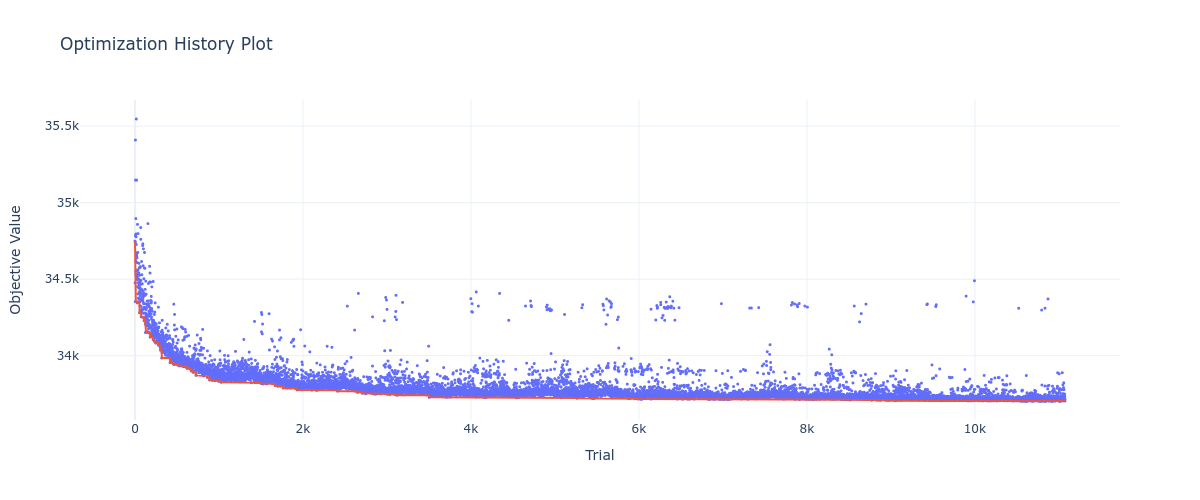

In [95]:
t_all = study.trials
t_best = study.best_trial
optuna_best_features = [k for k,v in t_best.params.items() if v==1]
optuna_best_features.sort()

print(f'total trials:            {len(t_all)}')
print(f'best trial:              {t_best.number}')
print(f'best trial value:        {t_best.value}')
print(f'time to find best value: {(t_best.datetime_complete - t_all[0].datetime_start).seconds:.4f} sec')
print(f'best feature count:      {len(optuna_best_features)}')
print(f'best features:           {optuna_best_features}')

fig = (
    optuna.visualization.plot_optimization_history(study)
    .update_traces({'marker': {'size': 3}})
    .update_layout(width=1200, height=500, showlegend=False)
)
fig.layout.template = 'plotly_white'
fig.show('png')

In [91]:
X_optuna = X[optuna_best_features].copy()
lin_mod_opt = sm.OLS(y, X_optuna, hasconst=True).fit()
print(lin_mod_opt.summary2())

                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.893     
Dependent Variable:        SalePrice              AIC:                      33697.5780
Date:                      2024-01-05 17:58       BIC:                      33871.8637
No. Observations:          1453                   Log-Likelihood:           -16816.   
Df Model:                  32                     F-statistic:              378.4     
Df Residuals:              1420                   Prob (F-statistic):       0.00      
R-squared:                 0.895                  Scale:                    6.7579e+08
--------------------------------------------------------------------------------------
                        Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
--------------------------------------------------------------------------------------
BedroomAbvGr           -5102.7841  1123.0646  -4.5436 0.0000   -7305.82

In [92]:
assert False

AssertionError: 

In [147]:
def cma_objective(fs):
    features_use = ['const'] + [f for i, f in enumerate(features_select) if fs[i,] == 1]
    lin_mod = sm.OLS(y, X[features_use], hasconst=True).fit()
    return lin_mod.bic


features_select = [f for f in X.columns if f != 'const']
cma_bounds = np.tile([0, 1], (len(features_select), 1))
cma_steps = np.ones(len(features_select))
optimizer = CMAwM(mean=np.zeros(len(features_select)), sigma=2.0, bounds=cma_bounds, steps=cma_steps, seed=0)
pop_size = optimizer.population_size

gen_max = 10000
best_value = np.inf
best_gen = 0
best_sol_raw = None
history_values = np.full((gen_max,), np.nan)
history_values_best = np.full((gen_max,), np.nan)

for generation in tqdm(range(gen_max)):
    best_value_gen = np.inf
    sol = []
    solutions = []
    vals = np.full((pop_size,), np.nan)

    for i in range(optimizer.population_size):
        fs_for_eval, fs_for_tell = optimizer.ask()
        solutions.append(fs_for_eval)
        value = cma_objective(fs_for_eval)
        vals[i] = value
        sol.append((fs_for_tell, value))
    optimizer.tell(sol)

    best_value_gen = vals.min()
    if best_value_gen < best_value:
        best_value = best_value_gen
        best_gen = generation
        best_sol_raw = solutions[np.argmin(vals)]
        print(f'gen: {best_gen:5n}, new best objective: {best_value:.4f}')
    history_values[generation] = best_value_gen
    history_values_best[generation] = best_value

    if optimizer.should_stop():
        break
gen_completed = generation

  0%|          | 0/10000 [00:00<?, ?it/s]

gen:     0, new best objective: 34455.0616
gen:     1, new best objective: 34302.1226
gen:     2, new best objective: 34241.2295
gen:     5, new best objective: 34187.4703
gen:     8, new best objective: 34158.3679
gen:     9, new best objective: 34113.5177
gen:    11, new best objective: 34015.5774
gen:    17, new best objective: 33993.0753
gen:    18, new best objective: 33984.9138
gen:    19, new best objective: 33973.6096
gen:    21, new best objective: 33952.4574
gen:    27, new best objective: 33951.9491
gen:    28, new best objective: 33942.5135
gen:    31, new best objective: 33927.7774
gen:    32, new best objective: 33921.4801
gen:    35, new best objective: 33918.4755
gen:    37, new best objective: 33894.7326
gen:    43, new best objective: 33882.5610
gen:    45, new best objective: 33866.2201
gen:    61, new best objective: 33857.6680
gen:    64, new best objective: 33853.7849
gen:    72, new best objective: 33846.6958
gen:    73, new best objective: 33838.2095
gen:    74,

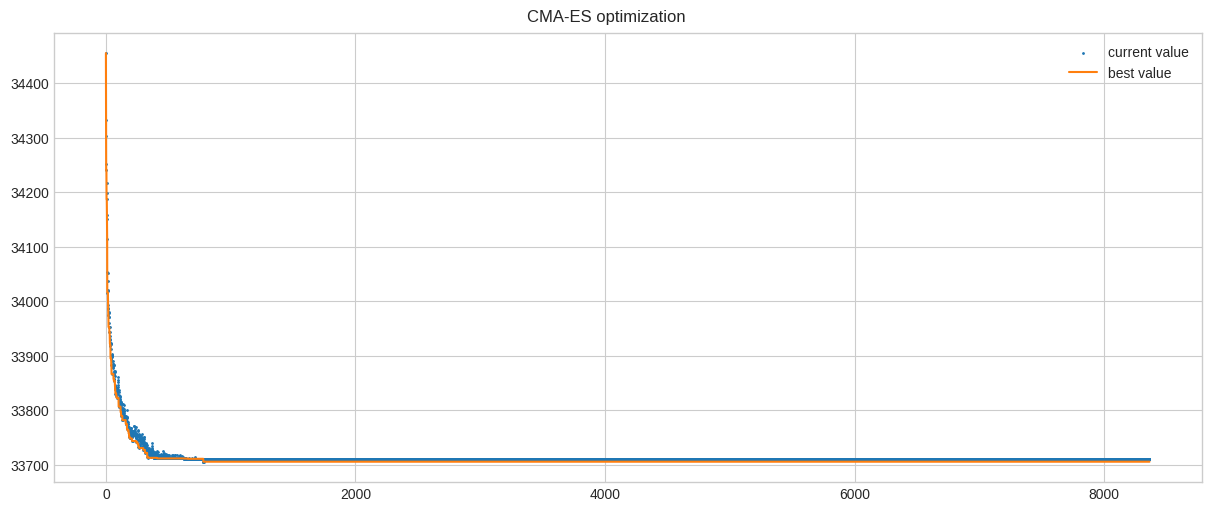

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), layout='constrained')
ax.scatter(range(gen_completed), history_values[:gen_completed], s=1, label='current value')
ax.plot(range(gen_completed), history_values_best[:gen_completed], c='C1', label='best value')
ax.legend()
fig.suptitle('CMA-ES optimization')
fig.show()